## Examining Co-evolution with amino-acid level resolution

While all of the interactions in our test set can be predicted by synteny, SCA and mirrortree have an interesting methodological advantage: the ability to estimate co-evolution at the resolution of individual amino acids. This can pinpoint which positions are most important to functional coupling, and might suggest strategies for designing multi-protein cell systems.

In this notebook, we examine how co-evolution between two proteins is distributed at the resolution of individual amino acids.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import coevo2 as ce
import scaTools as sca
import numpy as np
import itertools as it
from scipy import stats
import time
import copy

In [2]:
# If you need to edit the library code you can update the imported version using 'reload'
reload(ce)

<module 'coevo2' from 'coevo2.pyc'>

In [8]:
#make a nice blue-white-red colormap
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0,  0.230, 0.230),
                   (0.5,  0.865, 0.865),
                   (1.0,  0.706, 0.706)),

        'green': ((0.0,  0.299, 0.299),
                  (0.5,  0.865, 0.865),
                  (1.0,  0.016, 0.016)),

        'blue':  ((0.0,  0.754, 0.754),
                  (0.5,  0.865, 0.865),
                  (1.0,  0.150, 0.150))}
sci_bluered = LinearSegmentedColormap('BlueRed1', cdict)

### 1. Computing positional co-evolution. 

Here we compute co-evolution by SCA and mirrortree for: 1) the nrdA/nrdB physical complex and 2) the folA/thyA enzyme pair. In one case (nrdA/nrdB), we expect a signal that it is detectable by both mirrortree and SCA, wile in the other (folA/thyA) we expect signal from mirrortree only.

First, loading the data and constructing the phylogenetic model.

In [3]:
#create protsets corresponding to each protein pair
names1 = ['nrdA','nrdB']
names2 = ['folA','thyA']
algPath = 'TestSet/eggNOG_aligns/'
prots1 = ce.prots_from_scratch(names1,path2alg=algPath)
prots2 = ce.prots_from_scratch(names2,path2alg=algPath)
ps1 = ce.ProtSet(prots1,names1)
ps2 = ce.ProtSet(prots2,names2)

#create a phylogenetic model based on housekeeping genes
phylo_names = ['aspS','ffh','lepA','pgk','recN','rho','rpoA','ruvB','tig','uvrB']
phylo_prots = ce.prots_from_scratch(phylo_names,path2alg='TestSet/eggNOG_aligns/phylogenes/')
phylo1 = ce.PhyloSet(phylo_prots)
phylo1.set_indexer(thresh=7)
for pt in phylo1.prots:  # temporary fix for duplicated locus ids in the same msa
    pt.msa = pt.msa[~pt.msa.index.duplicated(keep='first')]
phylo1.set_sim_mat()

Keeping: 1641 species


#### Compute positional mirror tree

In [ ]:
#compute positional mirror tree for both nrdA/nrdB and folA/thyA
#Note: this step takes just over an hour on nucleus
#start_time = time.time()
#protmats1,pairmats1 = ce.pos_mirror_tree(ps1, phylo1, thread_lim = 1)
#print("--- nrdA/nrdB mirrortree complete: %.2f minutes ---" % ((time.time() - start_time)/60))
#for pt,posmt1 in it.izip(ps1.prots,protmats1): pt.pos_mt1 = posmt1
#for pair,posmt1 in it.izip(ps1.pairs,pairmats1): pair.pos_mt1 = posmt1
#np.save('nrdProtSet.npy',ps1)

#start_time = time.time()
#print("Starting second calc.")
#protmats2,pairmats2 = ce.pos_mirror_tree(ps2, phylo1, thread_lim = 1)
#print("--- folA/thyA mirrortree complete: %.2f minutes ---" % ((time.time() - start_time)/60))
#for pt,posmt1 in it.izip(ps2.prots,protmats2): pt.pos_mt1 = posmt1
#for pair,posmt1 in it.izip(ps2.pairs,pairmats2): pair.pos_mt1 = posmt1
#np.save('folProtSet.npy',ps2)

In [4]:
#or load mirror tree results from disk
ps1 = np.load('nrdProtSet.npy',encoding='latin1').flat[0]
ps2 = np.load('folProtSet.npy',encoding='latin1').flat[0]

#### Compute SCA

In [5]:
#compute SCA for both nrdA/nrdB and folA/thyA
#Note: this step takes a few minutes on my laptop
start_time = time.time()
protsmats1,pairmats1,pairmatsrc1,sca_score1_1,sca_score1_2 = ce.sca(ps1,phylo1)
print("--- %.2f minutes ---" % ((time.time() - start_time)/60))

start_time = time.time()
protsmats2,pairmats2,pairmatsrc2,sca_score1_1,sca_score1_2 = ce.sca(ps2,phylo1)
print("--- %.2f minutes ---" % ((time.time() - start_time)/60))

for pt,sca in it.izip(ps1.prots,protsmats1): pt.sca_mat = sca
for pair,sca_cat in it.izip(ps1.pairs,pairmats1): pair.sca_mat = sca_cat
for pair,sca_cat in it.izip(ps1.pairs,pairmatsrc1): pair.sca_matrc = sca_cat
for pt,sca in it.izip(ps2.prots,protsmats2): pt.sca_mat = sca
for pair,sca_cat in it.izip(ps2.pairs,pairmats2): pair.sca_mat = sca_cat
for pair,sca_cat in it.izip(ps2.pairs,pairmatsrc2): pair.sca_matrc = sca_cat
np.save('SCA_nrdAB.npy',ps1)
np.save('SCA_folAthyA.npy',ps2)

--- 0.55 minutes ---
--- 0.14 minutes ---


### 2. Compare the results of mirrortree and SCA

Create correlation plots relating the inter-protein positional co-evolution values for SCA and mirrortree. In the top row, we compare mirrortree to the raw SCA correlation matrix, in the bottom row, we compare mirrortree to the SCA correlation matrix after applying a "correction" for randomly occuring correlations.

For nrdA/nrdB: r=0.58 se=0.0087
For folA/thyA: r=0.68 se=0.0212
For nrdA/nrdB: r=0.64 se=0.0083
For folA/thyA: r=0.68 se=0.0275


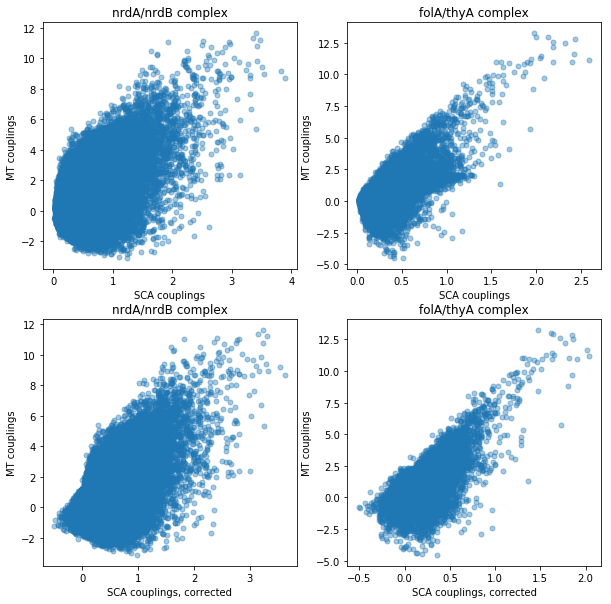

In [6]:
plt.rcParams['figure.figsize'] = 10,10

plt.subplot(221)
pair = ps1.get_pair('nrdA','nrdB')
plt.plot(pair.sca_mat.flatten(), pair.pos_mt1.flatten(),'o',markersize=5, alpha = 0.4)
m1,b1,r1,p1,se1 = stats.linregress(pair.sca_mat.flatten(),pair.pos_mt1.flatten())
plt.xlabel('SCA couplings')
plt.ylabel('MT couplings')
plt.title('nrdA/nrdB complex')
print('For nrdA/nrdB: r=%1.2f se=%1.4f' %(r1,se1))

plt.subplot(222)
pair2 = ps2.get_pair('folA','thyA')
plt.plot(pair2.sca_mat.flatten(), pair2.pos_mt1.flatten(),'o',markersize=5, alpha = 0.4)
m2,b2,r2,p2,se2 = stats.linregress(pair2.sca_mat.flatten(),pair2.pos_mt1.flatten())
plt.xlabel('SCA couplings')
plt.ylabel('MT couplings')
plt.title('folA/thyA complex')
print('For folA/thyA: r=%1.2f se=%1.4f' %(r2,se2))

plt.subplot(223)
pair = ps1.get_pair('nrdA','nrdB')
plt.plot(pair.sca_matrc.flatten(), pair.pos_mt1.flatten(),'o',markersize=5, alpha = 0.4)
m1,b1,r1,p1,se1 = stats.linregress(pair.sca_matrc.flatten(),pair.pos_mt1.flatten())
plt.xlabel('SCA couplings, corrected')
plt.ylabel('MT couplings')
plt.title('nrdA/nrdB complex')
print('For nrdA/nrdB: r=%1.2f se=%1.4f' %(r1,se1))

plt.subplot(224)
pair2 = ps2.get_pair('folA','thyA')
plt.plot(pair2.sca_matrc.flatten(), pair2.pos_mt1.flatten(),'o',markersize=5, alpha = 0.4)
m2,b2,r2,p2,se2 = stats.linregress(pair2.sca_matrc.flatten(),pair2.pos_mt1.flatten())
plt.xlabel('SCA couplings, corrected')
plt.ylabel('MT couplings')
plt.title('folA/thyA complex')
print('For folA/thyA: r=%1.2f se=%1.4f' %(r2,se2))

We observe that the mirrortree and SCA scores are generally somewhat correlated, irregardless of the randomized matrix correction to SCA. However, in some cases we observe appreciable SCA couplings associated with more modest mirrortree couplings. 

### 3. Examine how co-evolution is distributed across positions - mirrortree and SCA

First, we just plot the cross-protein mirrortree and SCA matrices side-by-side. 

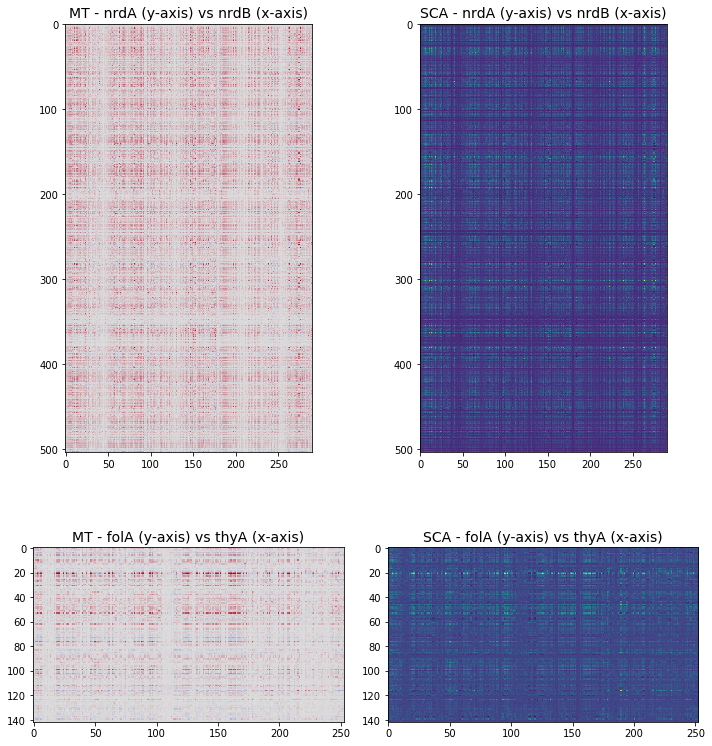

In [9]:
plt.figure(figsize=(10,12))
plt.subplot(221)
plt.imshow(pair.pos_mt1,cmap=sci_bluered,vmin=-10,vmax=10)
plt.title('MT - nrdA (y-axis) vs nrdB (x-axis)',fontsize=14)

plt.subplot(222)
plt.imshow(pair.sca_matrc,cmap='viridis')
plt.title('SCA - nrdA (y-axis) vs nrdB (x-axis)',fontsize=14)

plt.subplot(223)
plt.imshow(pair2.pos_mt1,cmap=sci_bluered,vmin=-10,vmax=10)
plt.title('MT - folA (y-axis) vs thyA (x-axis)',fontsize=14)

plt.subplot(224)
plt.imshow(pair2.sca_matrc,cmap='viridis')
plt.title('SCA - folA (y-axis) vs thyA (x-axis)',fontsize=14)

plt.tight_layout()

In both cases, we observe a spatially distributed pattern of couplings, in which many pairs of positions show only weak or very little coupling. In both cases, the matrices appear somewhat "stripey", in which a few positions carry more of the co-evolutionary signal. To identify these positions, we compute the average co-evolution per residue in each protein.

(array([ 8., 11., 17., 17., 19., 17., 29., 13., 13., 15.,  8.,  7.,  9.,
         9., 12., 12.,  7.,  8.,  6.,  3.,  2.,  7.,  3.,  0.,  1.]),
 array([-0.08452558, -0.03841502,  0.00769554,  0.05380609,  0.09991665,
         0.14602721,  0.19213776,  0.23824832,  0.28435888,  0.33046943,
         0.37657999,  0.42269054,  0.4688011 ,  0.51491166,  0.56102221,
         0.60713277,  0.65324333,  0.69935388,  0.74546444,  0.791575  ,
         0.83768555,  0.88379611,  0.92990667,  0.97601722,  1.02212778,
         1.06823833]),
 <a list of 25 Patch objects>)

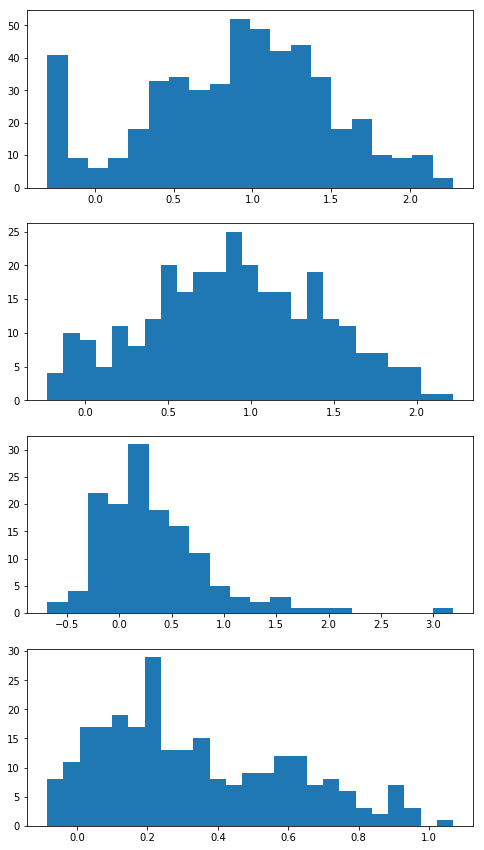

In [10]:
plt.figure(figsize=(8,15))
avgMT_nrdA = np.mean(pair.pos_mt1,axis=1)
avgMT_nrdB = np.mean(pair.pos_mt1,axis=0)
avgMT_folA = np.mean(pair2.pos_mt1,axis=1)
avgMT_thyA = np.mean(pair2.pos_mt1,axis=0)

plt.subplot(411)
plt.hist(avgMT_nrdA,20)
plt.subplot(412)
plt.hist(avgMT_nrdB,25)
plt.subplot(413)
plt.hist(avgMT_folA,20)
plt.subplot(414)
plt.hist(avgMT_thyA,25)

We observe a more heavy-tailed distribution of correlations for the folA/thyA pair. Is this a general trend for proteins that are functionally, but not physically coupled? And what explains the most highly co-evolving pairs? For the nrdA/nrdB complex, are the mostly highly co-evolving sites physically co-located? Is there any relationship to protein sequence conservation?